#### Loading packages

In [2]:
# Manipulations
import pandas as pd
import numpy as np
from numpy import inf

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import warnings
warnings.filterwarnings('ignore')

In [27]:
sns.set(rc = {'figure.figsize':(8, 5)})

#### Getting data

In [4]:
df = pd.read_csv("dataset/kag_conversion_data.csv")

#### Manipulations

In [5]:
df.columns = df.columns.str.lower()

#### EDA

Let's start by checking the data for any inconsistencies.

In [4]:
df.isna().sum()

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
impressions            0
clicks                 0
spent                  0
total_conversion       0
approved_conversion    0
dtype: int64

No NAs, however ...

In [5]:
print(df[['impressions', 'clicks', 'spent', 'approved_conversion']].describe())

        impressions       clicks        spent  approved_conversion
count  1.143000e+03  1143.000000  1143.000000          1143.000000
mean   1.867321e+05    33.390201    51.360656             0.944007
std    3.127622e+05    56.892438    86.908418             1.737708
min    8.700000e+01     0.000000     0.000000             0.000000
25%    6.503500e+03     1.000000     1.480000             0.000000
50%    5.150900e+04     8.000000    12.370000             1.000000
75%    2.217690e+05    37.500000    60.025000             1.000000
max    3.052003e+06   421.000000   639.949998            21.000000


* ... there are ads with 0 spent, however, they do have conversions. This might have happened because the clicks were not registered in the tracking or something else...
* The good thing is that almost every ad converts at least 1 person.
* Certain ads are quite expensive, that also needs to be investigated.

In [6]:
df[(df['clicks'] == 0)  & (df['total_conversion'] != 0)].groupby(['xyz_campaign_id']).size()

xyz_campaign_id
916      19
936     173
1178     12
dtype: int64

Most of the 0 spent ads happened in the case of campaign 936.

In [7]:
df.groupby(['ad_id']).size()
df.groupby(['xyz_campaign_id']).size()

xyz_campaign_id
916      54
936     464
1178    625
dtype: int64

We've got 3 campaigns, one proeminently having the least ads.

Let's go on and look at how users interact with the ads, by investigating the impressions vs. clicks relationship.

Text(0.5, 1.0, 'Number of Impressions vs. Number of Clicks')

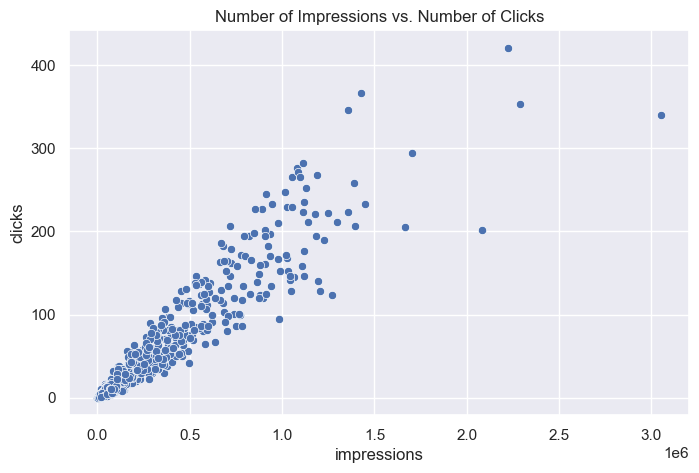

In [28]:
sns.scatterplot(data = df, x = 'impressions', y = 'clicks')
plt.title("Number of Impressions vs. Number of Clicks")

* Clearly, with more impressions there are more clicks. However, that does not always apply.
* A good way to see whether the campaigns are working effecetively is using the click-through-rate metric (CTR).

(array([300., 482., 266.,  71.,  19.,   3.,   0.,   1.,   0.,   1.]),
 array([0.        , 0.00010593, 0.00021186, 0.0003178 , 0.00042373,
        0.00052966, 0.00063559, 0.00074153, 0.00084746, 0.00095339,
        0.00105932]),
 <BarContainer object of 10 artists>)

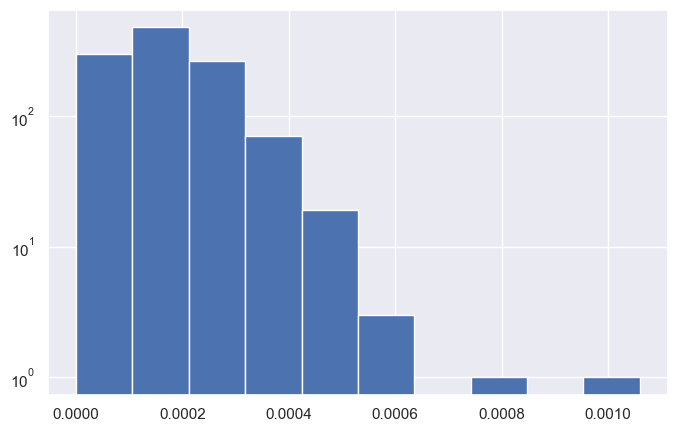

In [29]:
df['ctr'] = df['clicks'] / df['impressions']
plt.hist(df['ctr'], log = True)

* According to various sources, the average CTR for Facebook ads across all industries is around 0.9%. 
* For us here, most ads have a CTR that does not even reach 0.1%.
* That means one has to wait for at least 10000 impressions to get a click.

<AxesSubplot: xlabel='impressions', ylabel='ctr'>

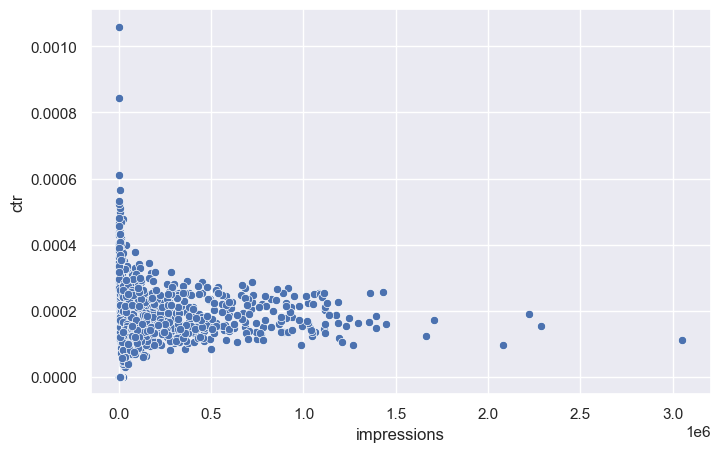

In [30]:
sns.scatterplot(x = df['impressions'], y = df['ctr'])

* But even, when there are more impressions, there are less clicks.
* The reasons for that can be a gazillion: poor targeting, young ads, etc.  

How does that translate into spent then?

(array([713., 160.,  71.,  52.,  30.,  26.,  18.,  20.,  14.,  11.,   8.,
          9.,   3.,   3.,   1.,   0.,   1.,   0.,   1.,   2.]),
 array([  0.        ,  31.99749991,  63.99499981,  95.99249972,
        127.98999962, 159.98749953, 191.98499943, 223.98249933,
        255.97999924, 287.97749915, 319.97499905, 351.97249895,
        383.96999886, 415.96749877, 447.96499867, 479.96249858,
        511.95999848, 543.95749839, 575.95499829, 607.95249819,
        639.9499981 ]),
 <BarContainer object of 20 artists>)

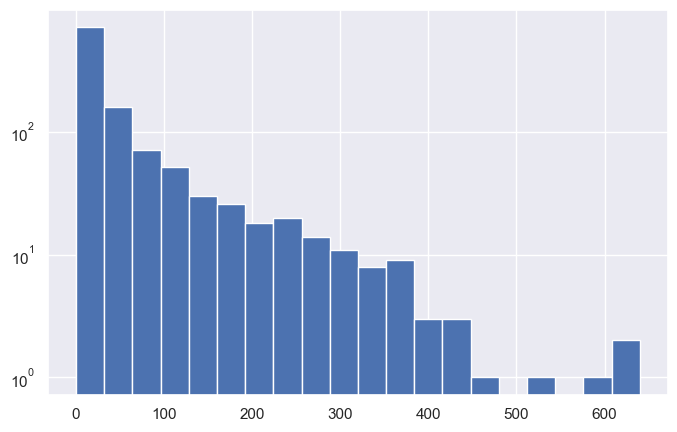

In [31]:
plt.hist(df['spent'], log = True, bins = 20)

* We can see most ads cost up to 200 dollars. 
* Facebook has two ways of payment: cost per click and cost per imression.

I would like to find out what could have been used here by looking at spent.

In [32]:
# Creating a bucket function to allow easy visualization.
def create_bucket(x):
    if 0 < x <= 300:
        return '1 - 200'
    elif 200 < x <= 400:
        return '200 - 400'
    elif x > 400:
        return '> 400'
    else:
        return '0'

df['spent_bucket'] = df['spent'].apply(create_bucket)

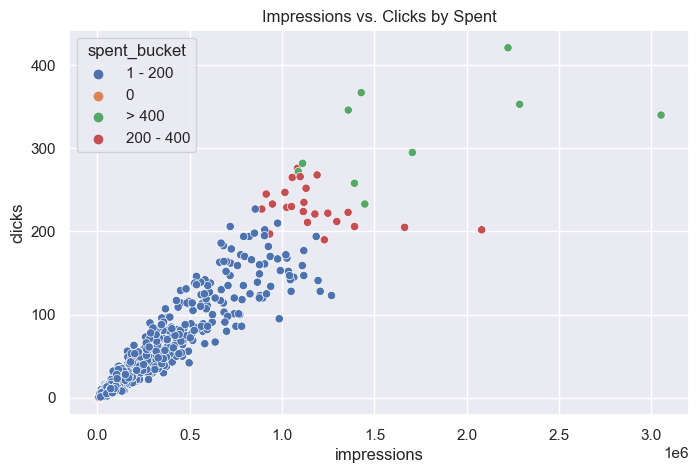

In [33]:
sns.scatterplot(data = df, x = 'impressions', y = 'clicks', hue = 'spent_bucket')
plt.title('Impressions vs. Clicks by Spent')
plt.show()

* So from what see here, it looks like Facebook ads are paid by cost per click and not cost per impression.
* This means, we will rely on CPC (cost per click) from now on.

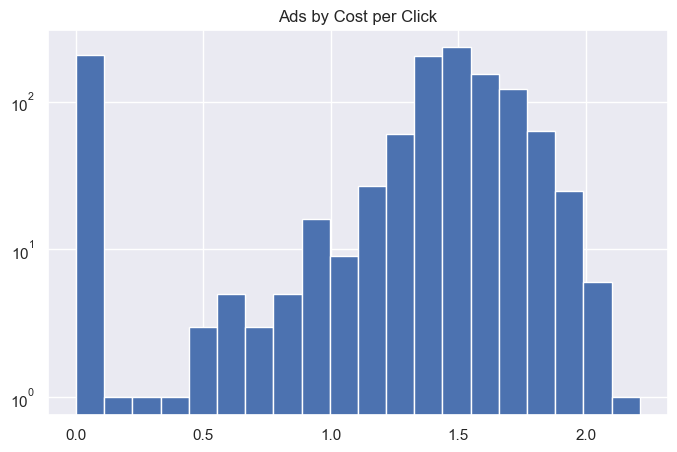

In [34]:
df['cpc'] = (df['spent'] / df['clicks']).fillna(0)
plt.hist(df['cpc'], log = True, bins = 20)
plt.title('Ads by Cost per Click')
plt.show()

* So as noticed before, we've got some ads with 0 clicks tracked.
* Generally, the CPC falls mostly somewhere between 1-2 dollars, which is expected by Facebook standards.

Let's see what that costs in terms of conversion.

In [35]:
# We've got two definitions of conversion, let's look at both.
df['cost_per_total_conversion'] = (df['spent'] / df['total_conversion']).fillna(0)
df['cost_per_total_conversion'] = df['cost_per_total_conversion'].replace([np.inf, -np.inf], 0)
df['cost_per_approved_conversion'] = (df['spent'] / df['approved_conversion']).fillna(0)
df['cost_per_approved_conversion'] = df['cost_per_approved_conversion'].replace([np.inf, -np.inf], 0)

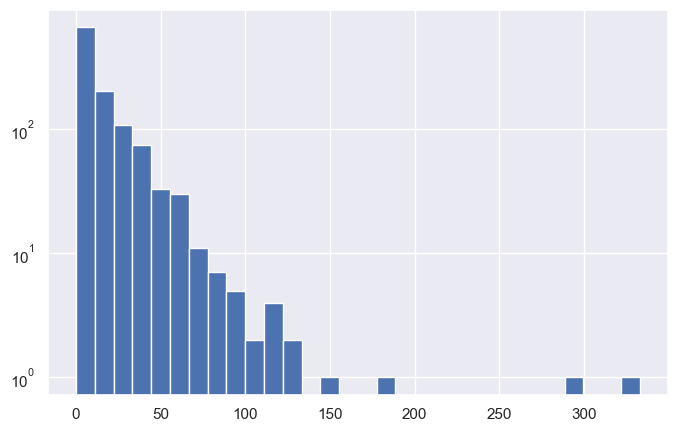

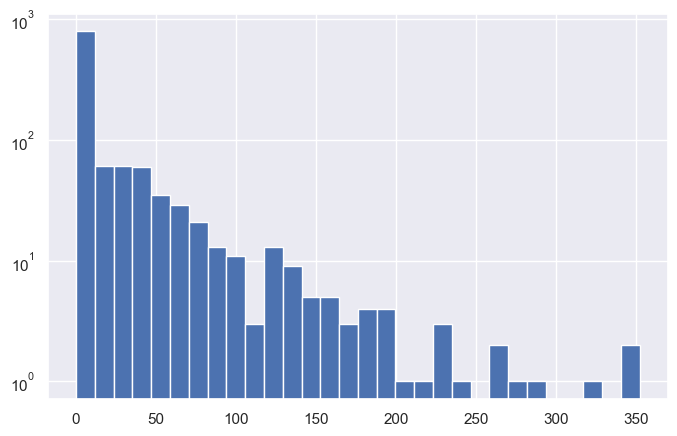

In [36]:
plt.hist(df['cost_per_total_conversion'], bins = 30, log = True)
plt.show()
plt.hist(df['cost_per_approved_conversion'], bins = 30, log = True)
plt.show()

* It costs less than 50$ to get an interest out of one person.
* Even if it costs more to get the person to buy the product, in most cases it is not much more expensive.
* Also, we've got a few ads that have a very high spend of more than 100. What is so special about them?

In [37]:
df[['total_conversion', 'approved_conversion', 'ctr','gender', 'age', 'interest', 'cost_per_total_conversion']][df['cost_per_total_conversion'] >= 100]


,total_conversion,approved_conversion,ctr,gender,age,interest,cost_per_total_conversion
207,1,0,0.000252,F,45-49,16,180.220001
771,1,0,0.000185,M,45-49,18,109.250001
812,3,1,0.000211,M,45-49,32,117.483333
996,2,0,0.000246,F,45-49,15,117.470000
999,1,0,0.000223,F,45-49,16,295.549996
1003,1,0,0.000255,F,45-49,18,332.989999
1005,1,0,0.000239,F,45-49,18,115.660001
1015,1,1,0.000249,F,45-49,22,145.819997
1016,1,1,0.000316,F,45-49,23,125.270001
1021,1,0,0.000251,F,45-49,25,105.660001


Interestingly, most of these ads have targeted females in the age of 45-49. Can we ask then - do women click more than men? 
Will enquire that in a few moments. I would want to stay here for a bit and investigate the conversion cost.

Text(0.5, 1.0, 'Number of Ads by Approved Cost Multiplier')

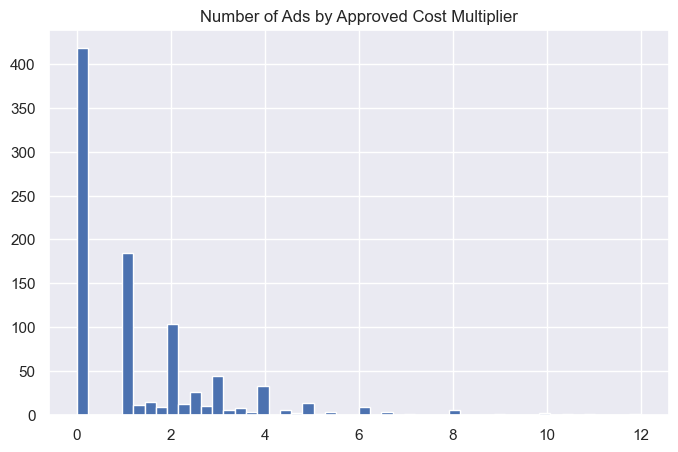

In [38]:
plt.hist(df['cost_per_approved_conversion'] / df['cost_per_total_conversion'], bins = 50)
plt.title("Number of Ads by Approved Cost Multiplier")

We've got almost 200 ads where we can see the cost of total and approved conversion is the same.  
That means that people enquired and bought.

Text(0.5, 1.0, 'Number of Ads by Approved Cost Multiplier')

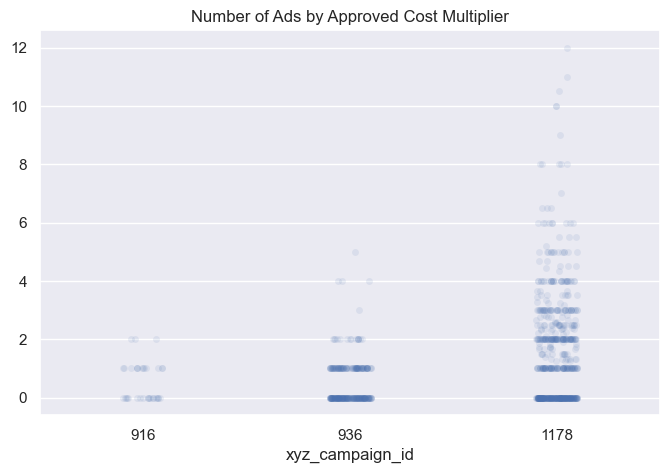

In [39]:
sns.stripplot(data = df, x = 'xyz_campaign_id',y = df['cost_per_approved_conversion'] / df['cost_per_total_conversion'], alpha = 0.1)
plt.title("Number of Ads by Approved Cost Multiplier")

Also, that is not a special behavior across campaigns.

Text(0.5, 1.0, 'Ads by Conversion Rate')

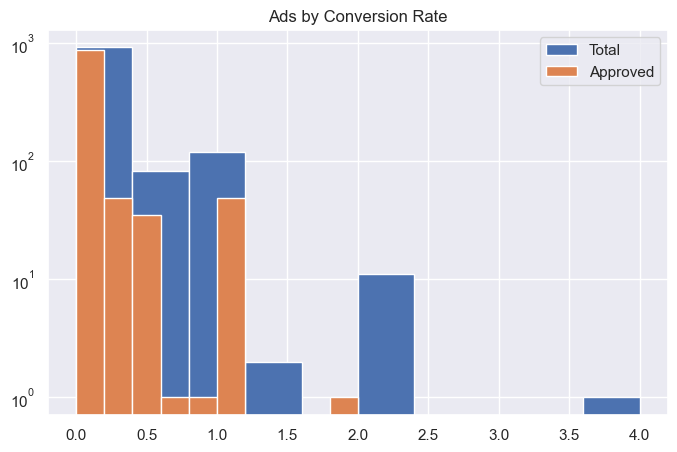

In [40]:
df['total_conversion_rate'] = df['total_conversion'] / df['clicks']
df['total_conversion_rate'] = df['total_conversion_rate'].replace([np.inf, -np.inf], 0)
df['approved_conversion_rate'] = df['approved_conversion'] / df['clicks']
df['approved_conversion_rate'] = df['approved_conversion_rate'].replace([np.inf, -np.inf], 0)
plt.hist(df['total_conversion_rate'], log = True, label = 'Total')
plt.hist(df['approved_conversion_rate'], log = True, label = 'Approved')
plt.legend()
plt.title('Ads by Conversion Rate')

* Across industries, the average conversion rate is about 9-10%.  We here, have very high conversion rates for total converion rate, the average is around 25%. 
* Whereas approved conversion rate is around the Facebook average conversion rate.
* Important to note, that there are times when total conversions are higher than clicks. It could either be because there was a problem in the tracking or actually users enquire more times than they click ads.

Going back to the question I had before - **Does gender matter for conversion**?

In [41]:
df.groupby(['gender']).size()

gender
F    551
M    592
dtype: int64

So, the number of ads is mostly balanced between genders. That makes it easier to compare.

<AxesSubplot: xlabel='gender', ylabel='spent'>

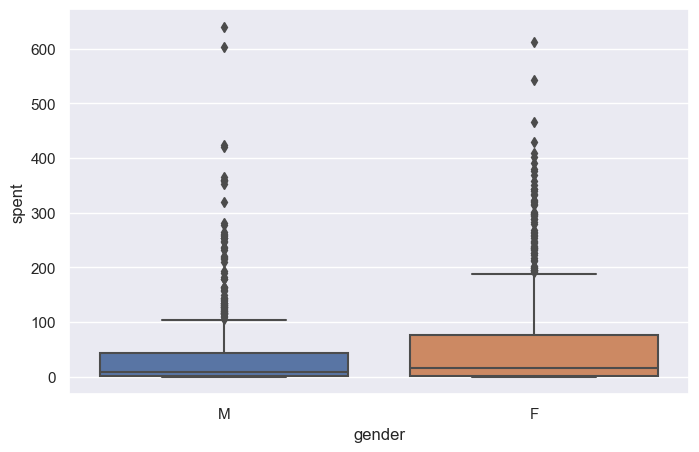

In [42]:
sns.boxplot(x = df['gender'], y = df['spent'])

More is spent on ads that are seen by women and ...

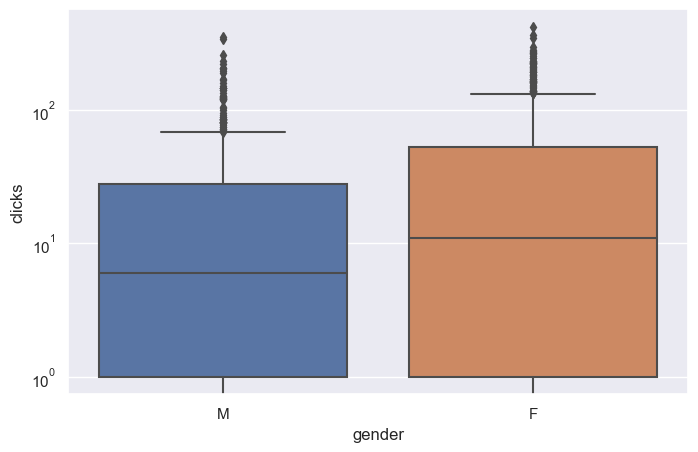

In [43]:
sns.boxplot(x = df['gender'], y = df['clicks'])
plt.yscale("log")

... that is a result of women clicking more. And actually ...

<AxesSubplot: xlabel='gender', ylabel='ctr'>

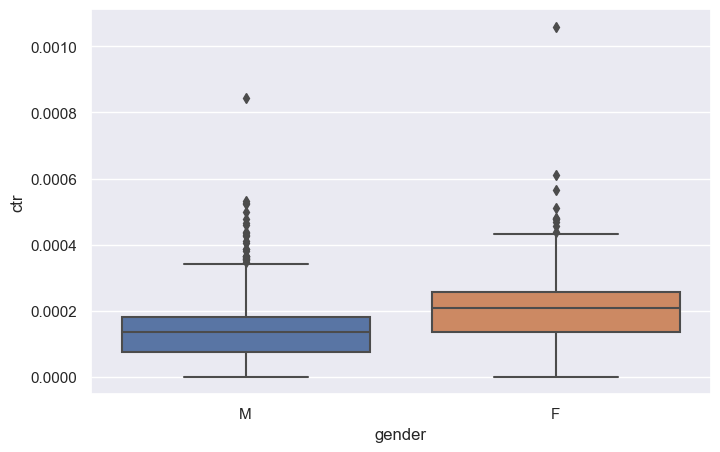

In [44]:
sns.boxplot(x = df['gender'], y = df['ctr'])

* ... the CTR is higher for women. That means if they see an add, they are more likely to click.
* Also, let's bear in mind - we have a higher proportion of men seeing ads than women.

So, does that eventually pay off?

In [45]:
print(df[['spent','ctr', 'total_conversion_rate', 'approved_conversion', 'approved_conversion_rate', 'gender']].groupby("gender").aggregate("mean"))
print(df[['spent','ctr', 'total_conversion_rate', 'approved_conversion', 'approved_conversion_rate', 'gender']].groupby("gender").aggregate("median"))

            spent       ctr  total_conversion_rate  approved_conversion  \
gender                                                                    
F       62.618185  0.000194               0.218626             0.898367   
M       40.882787  0.000137               0.264282             0.986486   

        approved_conversion_rate  
gender                            
F                       0.089240  
M                       0.112813  
        spent       ctr  total_conversion_rate  approved_conversion  \
gender                                                                
F       16.41  0.000207               0.081441                  0.0   
M        9.57  0.000136               0.103227                  1.0   

        approved_conversion_rate  
gender                            
F                       0.000000  
M                       0.012579  


Well, women are less likely to buy the product, which results in much higher cost for the company.  
Is there something happing at the enquirement stage that does not satisfy them or is there something more?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 [Text(0, 0, '2'),
  Text(1, 0, '7'),
  Text(2, 0, '10'),
  Text(3, 0, '15'),
  Text(4, 0, '16'),
  Text(5, 0, '18'),
  Text(6, 0, '19'),
  Text(7, 0, '20'),
  Text(8, 0, '21'),
  Text(9, 0, '22'),
  Text(10, 0, '23'),
  Text(11, 0, '24'),
  Text(12, 0, '25'),
  Text(13, 0, '26'),
  Text(14, 0, '27'),
  Text(15, 0, '28'),
  Text(16, 0, '29'),
  Text(17, 0, '30'),
  Text(18, 0, '31'),
  Text(19, 0, '32'),
  Text(20, 0, '36'),
  Text(21, 0, '63'),
  Text(22, 0, '64'),
  Text(23, 0, '65'),
  Text(24, 0, '66'),
  Text(25, 0, '100'),
  Text(26, 0, '101'),
  Text(27, 0, '102'),
  Text(28, 0, '103'),
  Text(29, 0, '104'),
  Text(30, 0, '105'),
  Text(31, 0, '106'),
  Text(32, 0, '107'),
  Text(33, 0, '108'),
  Text(34, 0, '109'),
  Text(35, 0, '110'),
  Text(36, 0, '111'),
  Text(37, 0, '112'),
  Text(38, 0, '

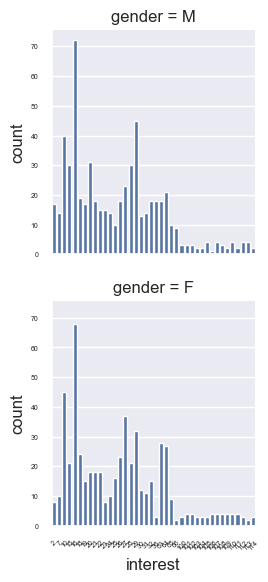

In [46]:
g = sns.FacetGrid(df, row = 'gender')
g.map(sns.countplot, 'interest')
g.tick_params(labelsize = 5)
plt.xticks(rotation = 45)

In terms of interest, there is not much of a difference between men and women.  
I would skip the "interest" variable for further analysis as we do not have much data anyways, and this is more interesting to look at when there is more data.

**Would age be another factor to consider?**  
Before we make this thing more complicated let's look at age solely, and then combine these two later on.

In [47]:
df.groupby(['age']).size()

age
30-34    426
35-39    248
40-44    210
45-49    259
dtype: int64

* Most ads are seen by young adults between 30-34. According to Facebook, 
* Most users in 2023 are between 24-34, as seen here https://www.statista.com/statistics/187549/facebook-distribution-of-users-age-group-usa/
* The split of the group is different, but that already tells us that it's young adults that use it mostly, and from there the distribution falls.

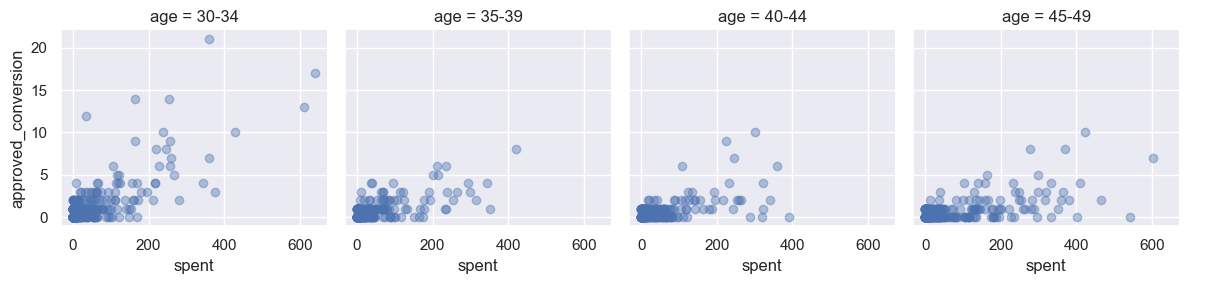

In [49]:
g = sns.FacetGrid(df, col = "age")
g.map(plt.scatter, "spent", "approved_conversion", alpha=.4)
g.add_legend()

We are seeing something here. The older, the higher spent per ad, as they click more on ads.

In [50]:
df['total_approved_conversion_rate'] = df['approved_conversion'] / df['total_conversion']
print(df[['spent','ctr', 'total_conversion_rate', 'approved_conversion_rate', 'total_approved_conversion_rate','age']].groupby("age").aggregate("mean"))

           spent       ctr  total_conversion_rate  approved_conversion_rate  \
age                                                                           
30-34  35.803756  0.000116               0.316198                  0.134279   
35-39  44.808185  0.000163               0.252823                  0.117691   
40-44  55.189190  0.000200               0.189544                  0.071011   
45-49  80.118417  0.000215               0.153974                  0.062627   

       total_approved_conversion_rate  
age                                    
30-34                        0.350903  
35-39                        0.346985  
40-44                        0.354281  
45-49                        0.300085  


* Looking at some statistics, that is so. In terms of conversion, there is a downward tendency, but it's not big enough to say that this is a huge difference. 
* Across ages, in 30% of cases of enquiring the product, a product is bought.
* If we knew what product is being sold here, had the revenue, that combined with the conversion rate would make this thing more explanatory.

In [51]:
print(df[['spent','total_conversion', 'approved_conversion', 'age']].groupby("age").aggregate("sum"))

              spent  total_conversion  approved_conversion
age                                                       
30-34  15252.399986              1431                  494
35-39  11112.429994               626                  207
40-44  11589.729981               523                  170
45-49  20750.669997               684                  208


Now, going back to our beloved gender topic. 

In [52]:
df.groupby(['age', 'gender']).size()

age    gender
30-34  F         197
       M         229
35-39  F         109
       M         139
40-44  F         107
       M         103
45-49  F         138
       M         121
dtype: int64

In the data, we have in the young adult bucket much more men and the older bucket a bit more women in the target group.

<AxesSubplot: xlabel='ctr', ylabel='approved_conversion_rate'>

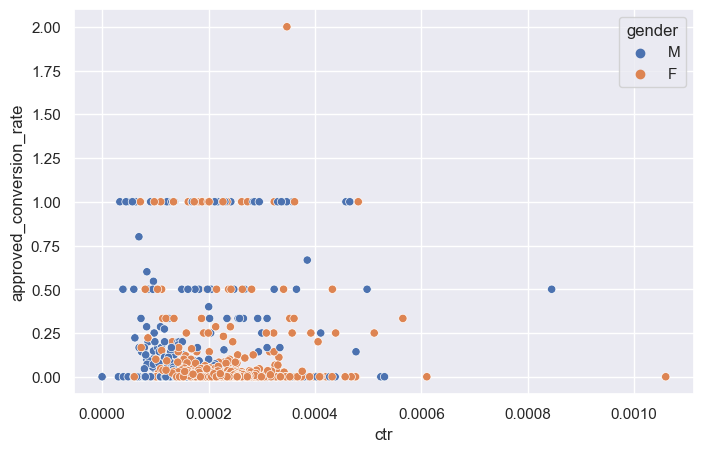

In [53]:
sns.scatterplot(data = df, x = 'ctr', y = 'approved_conversion_rate', hue = 'gender')

Although women have a higher CTR than men across the available age groups ...

<AxesSubplot: xlabel='age', ylabel='ctr'>

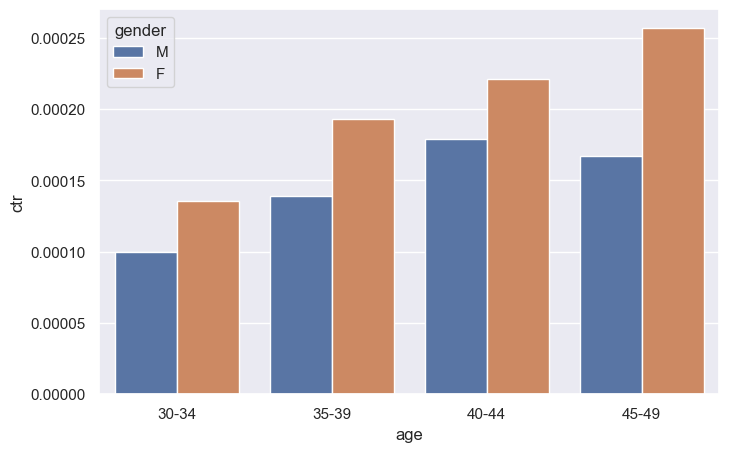

In [54]:
sns.barplot(data = df, x = 'age', y = 'ctr', hue = 'gender', ci = None)

Across ages as well ...

<AxesSubplot: xlabel='age', ylabel='approved_conversion_rate'>

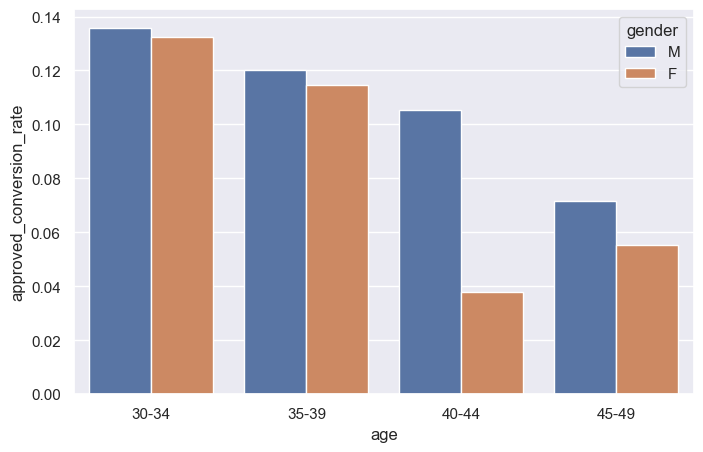

In [55]:
sns.barplot(data = df, x = 'age', y = 'approved_conversion_rate', hue = 'gender', ci = None)

... women are less likely to buy the product, especially those older than 40.

<AxesSubplot: xlabel='age', ylabel='cpc'>

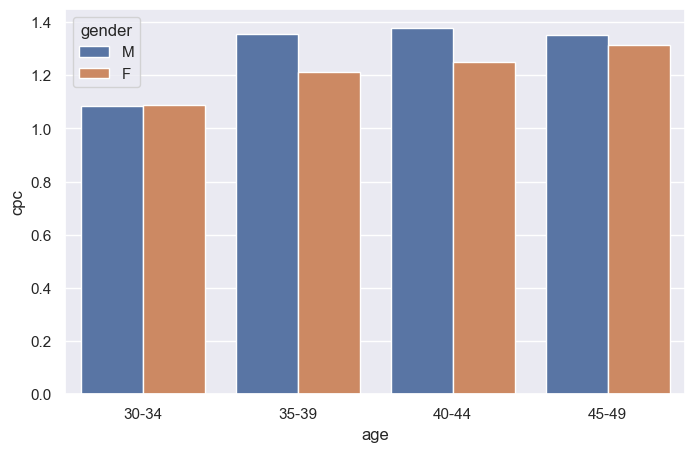

In [56]:
sns.barplot(data = df, x = 'age', y = 'cpc', hue = 'gender', ci = None)

So, even if the CPC is cheaper for women, as they tend to click more ...

<AxesSubplot: xlabel='age', ylabel='cost_per_approved_conversion'>

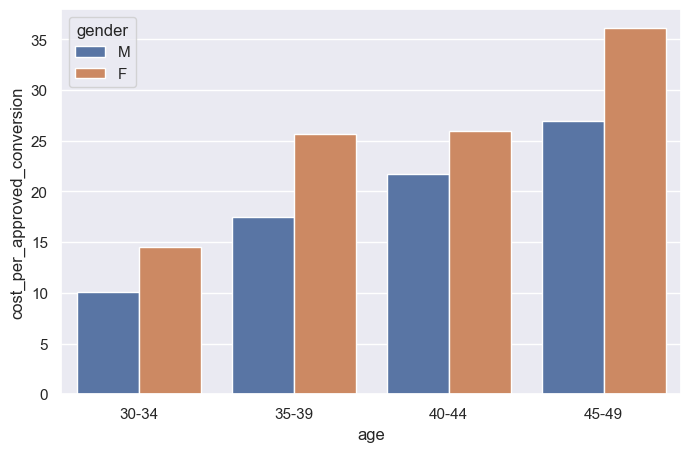

In [57]:
sns.barplot(data = df, x = 'age', y = 'cost_per_approved_conversion', hue = 'gender', ci = None)

... eventually across all ages, ads result more expensive across all female age groups.